# Heteroscedastic NLL + Right-Censoring — Data-Flow Focused Notebook

End-to-end PyTorch example emphasizing **data flow** from Dataset → DataLoader → Model → Loss → Metrics → Plots.



## Learning Objectives
- Per-sample dict structure in `Dataset.__getitem__` (x, y, is_cen, c, w).
- Weighted heteroscedastic Gaussian NLL and a right-censoring survival term.
- Safe weighted sampling and normalized weighted loss.
- Validation plots: prediction vs ground truth; residuals on observed samples.



## Data Flow Map
```
Dataset.__getitem__ -> {"x","y","is_cen","c","w"} tensors
make_loaders -> DataLoader batches of dicts (maybe WeightedRandomSampler)
train_one_epoch -> forward (mu, log_var) -> per-sample loss -> weighted mean
evaluate -> val_loss + RMSE (observed only)
predict -> arrays used by plots
```


In [9]:
# ---
# Cell overview: import core libraries, configure typing helpers, and seed numpy/torch for reproducibility.
# Downstream cells rely on these imports and the deterministic seeds to keep samples and model training repeatable.
# ---
# Setup
# !pip install torch numpy matplotlib
import math
from dataclasses import dataclass
from typing import Tuple, Dict, Any, List
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
torch.manual_seed(0); np.random.seed(0)


### 1. Dataset

In [10]:
# ---
# Cell overview: define the synthetic censored regression dataset, including latent function f, noisy observations,
# censoring thresholds, per-sample weights, and an accessor that returns tensors used by the loaders and plots.
# The dataset now also exposes f_clean so later visualizations can compare predictions to the noise-free target.
# ---
# Custom dataset inheriting from torch.utils.data.Dataset
# Implements __len__ and __getitem__ to be compatible with DataLoader.
class ToyCensoredDataset(Dataset):
    def __init__(self, n=3000, p=5, target_censor_rate=0.3, seed=0):
        super().__init__()
        # Call parent Dataset constructor (good practice, even though it's empty).

        # --- Generate synthetic features ---
        rng = np.random.default_rng(seed)                  # Random generator (reproducible)
        self.x = rng.uniform(-2, 2, size=(n, p)).astype(np.float32)
        # Shape (n, p) features ~ U[-2,2]; think of each row as one "sample"

        # --- Define true underlying function (signal) ---
        f = (np.tanh(self.x[:, 0])                         # nonlinear dependence on feature 0
             + 0.5 * np.sin(2 * self.x[:, 1])              # oscillatory dependence on feature 1
             + 0.2 * (self.x[:, 2] ** 2))                  # quadratic dependence on feature 2
        f = f.astype(np.float32)

        # --- Define heteroscedastic noise (sigma depends on x[:,3]) ---
        true_sigma = 0.1 + 0.4 * (self.x[:, 3] + 2) / 4.0  # ranges roughly 0.1-0.5

        # Sample Gaussian noise with variance depending on x
        noise = rng.normal(0.0, true_sigma).astype(np.float32)

        # Observed raw targets
        y_raw = (f + noise).astype(np.float32)

        # --- Define censoring threshold ---
        c = (f + np.quantile(true_sigma, 0.7)).astype(np.float32)
        # Threshold is just above mean, so some points are censored

        # --- Mark censored samples (right-censoring) ---
        is_cen = (y_raw > c)     # 1 if censored, 0 otherwise

        # Optionally increase censoring rate to target_censor_rate by "promoting" uncensored samples
        cur_rate = is_cen.mean()
        if cur_rate < target_censor_rate:
            need = int(target_censor_rate * n - is_cen.sum())  # how many to promote
            idx_pool = np.where(~is_cen)[0]                    # indices of uncensored
            if need > 0 and idx_pool.size > 0:
                promote = rng.choice(idx_pool, size=min(need, idx_pool.size), replace=False)
                is_cen[promote] = True

        # --- Define per-sample weights (quality scores) ---
        q = 1.0 / (true_sigma + 1e-8)        # inverse variance weighting
        q = (q / np.median(q)).astype(np.float32)  # normalize by median
        q = np.clip(q, 0.25, 4.0)            # clip to avoid extreme weights

        # --- Store final arrays as attributes ---
        self.f_clean = f.astype(np.float32)        # noiseless latent function values
        self.y_true = y_raw.astype(np.float32)     # observed targets (with noise)
        self.c = c.astype(np.float32)              # censoring threshold
        self.is_cen = is_cen.astype(np.int64)      # censoring indicator (0/1)
        self.w = q.astype(np.float32)              # sample weight

    def __len__(self):
        # Return total number of samples
        return len(self.y_true)

    def __getitem__(self, i):
        # Return sample i as a dictionary of tensors
        return {
            "x": torch.from_numpy(self.x[i]),          # features (p-dimensional vector)
            "y": torch.tensor(self.y_true[i]),         # target scalar
            "is_cen": torch.tensor(self.is_cen[i]),    # censoring flag
            "c": torch.tensor(self.c[i]),              # censoring threshold
            "w": torch.tensor(self.w[i]),              # sample weight
            "f_clean": torch.tensor(self.f_clean[i])   # noiseless target value
        }




### 2. Model

In [11]:
# ---
# Cell overview: declare the heteroscedastic MLP regressor with shared backbone and separate heads for mean and log variance.
# The forward pass clamps log-variance for numerical stability so the loss remains well behaved during training.
# ---
class HeteroRegressor(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.backbone = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(),
                                      nn.Linear(hidden, hidden), nn.ReLU())
        self.head_mu = nn.Linear(hidden, 1)
        self.head_log_var = nn.Linear(hidden, 1)
    def forward(self, x):
        h = self.backbone(x)
        mu = self.head_mu(h).squeeze(-1)
        log_var = self.head_log_var(h).squeeze(-1)
        return mu, torch.clamp(log_var, min=-10.0, max=5.0)


### 3. Losses

In [12]:
# ---
# Cell overview: implement the loss stack consisting of Gaussian NLL for observed samples, the right-censoring tail term,
# and a weighted combination that normalizes by total weight; these functions are reused in training and evaluation.
# ---
def gaussian_nll(mu, log_var, y):
    var = log_var.exp().clamp_min(1e-12)
    return (y - mu)**2 / var + log_var
def right_censored_tail_nll(mu, log_var, c):
    std = (0.5 * log_var).exp().clamp_min(1e-12)
    z = (c - mu)/std
    tail = 1.0 - Normal(0,1).cdf(z)
    return -torch.log(torch.clamp(tail, min=1e-12))
def weighted_censored_loss(mu, log_var, y, is_cen, c, w):
    nll_obs = gaussian_nll(mu, log_var, y)
    nll_cen = right_censored_tail_nll(mu, log_var, c)
    per_sample = torch.where(is_cen.bool(), nll_cen, nll_obs)
    w = torch.clamp(w, min=1e-6)
    return (w * per_sample).sum() / w.sum()


### 4. Data Loaders & Config

In [13]:
# ---
# Cell overview: capture training hyperparameters in a dataclass, optionally visualize freshly created datasets,
# and build train/validation DataLoaders with either a weighted sampler or shuffled batching; this wires the data flow.
# ---
from dataclasses import dataclass
@dataclass
class TrainConfig:
    batch_size:int=128; epochs:int=80; lr:float=2e-3; weight_decay:float=1e-4
    use_weighted_sampler:bool=True; grad_clip:float=5.0
    # Visualization of datasets at creation time
    visualize_ds:bool=False; viz_max:int=1000

def _visualize_dataset(ds, title_prefix="", max_points=1000):
    import numpy as _np
    import matplotlib.pyplot as _plt
    n = len(ds.y_true)
    idx = _np.arange(n)
    if n > max_points:
        rng = _np.random.default_rng(0)
        idx = rng.choice(n, size=max_points, replace=False)
    y = _np.asarray(ds.y_true)[idx]
    c = _np.asarray(ds.c)[idx]
    is_cen = _np.asarray(ds.is_cen)[idx].astype(bool)
    w = _np.asarray(ds.w)[idx]

    fig, axes = _plt.subplots(1, 3, figsize=(12,3))
    axes[0].hist(y, bins=40, alpha=0.8, color="tab:blue")
    axes[0].set_title(f'{title_prefix} y distribution (n={n})')
    axes[0].set_xlabel('y'); axes[0].set_ylabel('count')

    axes[1].hist(c, bins=40, alpha=0.8, color="tab:orange")
    axes[1].set_title(f'{title_prefix} c (threshold)')
    axes[1].set_xlabel('c'); axes[1].set_ylabel('count')

    sc = axes[2].scatter(y, c, s=6, c=_np.where(is_cen, 1, 0), cmap="coolwarm", alpha=0.7)
    axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1, alpha=0.5)
    axes[2].set_title(f'{title_prefix} y vs c (color=is_cen)')
    axes[2].set_xlabel('y'); axes[2].set_ylabel('c')
    fig.colorbar(sc, ax=axes[2], fraction=0.046, pad=0.04)
    _plt.tight_layout()
    _plt.show()

    # Print quick summary
    cen_rate = float(is_cen.mean())
    print(f'{title_prefix} n={n}, censor_rate={cen_rate:.3f}, w[min/med/max]={float(w.min()):.3f}/{float(_np.median(w)):.3f}/{float(w.max()):.3f}')

def make_loaders(n_train=1500, n_val=500, p=5, censor_rate=0.3, seed=0, cfg:TrainConfig=TrainConfig()):
    ds_train = ToyCensoredDataset(n=n_train, p=p, target_censor_rate=censor_rate, seed=seed)
    ds_val   = ToyCensoredDataset(n=n_val,   p=p, target_censor_rate=censor_rate, seed=seed+1)

    # Optional visualization at creation time
    if getattr(cfg, 'visualize_ds', False):
        _visualize_dataset(ds_train, title_prefix='Train', max_points=getattr(cfg, 'viz_max', 1000))
        _visualize_dataset(ds_val,   title_prefix='Val',   max_points=getattr(cfg, 'viz_max', 1000))

    # Build loaders (with optional weighted sampler)
    if cfg.use_weighted_sampler:
        weights = torch.as_tensor(ds_train.w, dtype=torch.double)
        sampler = WeightedRandomSampler(weights=weights, num_samples=len(ds_train), replacement=True)
        train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(ds_val, batch_size=512, shuffle=False)
    return ds_train, ds_val, train_loader, val_loader


### 5. Training & Evaluation

In [14]:
# ---
# Cell overview: provide the optimization loop (one epoch), validation routine, and higher-level training orchestrator.
# Tracks weighted loss, clips gradients if requested, logs validation metrics, and returns history for later inspection.
# ---
def train_one_epoch(model, loader, opt, device, cfg):
    model.train(); total=0.0
    for batch in loader:
        x,y,is_cen,c,w = (batch[k].to(device) for k in ["x","y","is_cen","c","w"])
        mu, log_var = model(x)
        loss = weighted_censored_loss(mu, log_var, y, is_cen, c, w)
        opt.zero_grad(); loss.backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.grad_clip)
        opt.step(); total += loss.item()*x.size(0)
    return total/len(loader.dataset)
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); losses=[]; rmses=[]
    for batch in loader:
        x,y,is_cen,c,w = (batch[k].to(device) for k in ["x","y","is_cen","c","w"])
        mu, log_var = model(x)
        loss = weighted_censored_loss(mu, log_var, y, is_cen, c, w); losses.append(loss.item())
        mask = ~is_cen.bool()
        if mask.any():
            rmse = torch.sqrt(torch.mean((mu[mask]-y[mask])**2)).item(); rmses.append(rmse)
    return {"val_loss": float(np.mean(losses)) if losses else float("nan"),
            "val_rmse_obs": float(np.mean(rmses)) if rmses else float("nan")}
def fit(model, train_loader, val_loader, device, cfg):
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    history={"train_loss":[], "val_loss":[], "val_rmse_obs":[]}
    for epoch in range(1, cfg.epochs+1):
        tr=train_one_epoch(model, train_loader, opt, device, cfg)
        ev=evaluate(model, val_loader, device)
        history["train_loss"].append(tr); history["val_loss"].append(ev["val_loss"]); history["val_rmse_obs"].append(ev["val_rmse_obs"])
        print(f"Epoch {epoch:02d} | train_loss={tr:.4f}  val_loss={ev['val_loss']:.4f}  val_RMSE_obs={ev['val_rmse_obs']:.4f}")
    return history


### 6. Prediction & Plots

In [15]:
# ---
# Cell overview: gather predictions, uncertainty, and metadata for the validation set, then define plotting utilities for
# prediction vs truth, residual histograms, and the true latent function compared to model outputs with confidence bands.
# ---
@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    out = {"mu": [], "std": [], "y_true": [], "is_cen": [], "c": [], "f_clean": []}
    for batch in loader:
        x, y, is_cen, c = (batch[k].to(device) for k in ["x", "y", "is_cen", "c"])
        mu, log_var = model(x)
        std = (0.5 * log_var).exp()
        out["mu"].append(mu.cpu().numpy())
        out["std"].append(std.cpu().numpy())
        out["y_true"].append(y.cpu().numpy())
        out["is_cen"].append(is_cen.cpu().numpy())
        out["c"].append(c.cpu().numpy())
        if "f_clean" in batch:
            out["f_clean"].append(batch["f_clean"].cpu().numpy())
    return {k: np.concatenate(v) if v else np.array([]) for k, v in out.items()}

def plot_pred_vs_true(y_true, mu, is_cen, title_prefix='Validation'):
    plt.figure()
    idx_obs = ~is_cen
    plt.scatter(y_true[idx_obs], mu[idx_obs], s=10, label='Observed')
    idx_cen = is_cen
    if idx_cen.any():
        plt.scatter(y_true[idx_cen], mu[idx_cen], s=10, marker='x', label='Censored')
    miv = float(np.min([y_true.min(), mu.min()]))
    mav = float(np.max([y_true.max(), mu.max()]))
    plt.plot([miv, mav], [miv, mav], linewidth=1, linestyle='--', label='y=x')
    plt.xlabel('Ground truth y')
    plt.ylabel('Predicted mu')
    plt.title(f'{title_prefix}: Prediction vs Ground Truth')
    plt.legend()
    plt.show()

def plot_residuals(y_true, mu, is_cen, title_prefix='Validation'):
    idx_obs = ~is_cen
    if not idx_obs.any():
        return
    res = mu[idx_obs] - y_true[idx_obs]
    plt.figure()
    plt.hist(res, bins=40)
    plt.xlabel('Residual (mu - y)')
    plt.ylabel('Count')
    plt.title(f'{title_prefix}: Residuals (Observed Only)')
    plt.show()

def plot_true_function_vs_pred(f_true, mu, std, title_prefix='Validation'):
    if f_true.size == 0:
        return
    order = np.argsort(f_true)
    f_sorted = f_true[order]
    mu_sorted = mu[order]
    std_sorted = std[order]
    x_idx = np.arange(f_true.size)
    plt.figure(figsize=(8, 4))
    plt.plot(x_idx, f_sorted, label='True f (noise-free)', linewidth=1.5)
    plt.plot(x_idx, mu_sorted, label='Predicted mean', linewidth=1.5)
    plt.fill_between(x_idx, mu_sorted - 2.0 * std_sorted, mu_sorted + 2.0 * std_sorted,
                     color='tab:blue', alpha=0.2, label='Predicted +/- 2 std')
    plt.xlabel('Sample index (sorted by true f)')
    plt.ylabel('Value')
    plt.title(f'{title_prefix}: True Function vs Prediction')
    plt.legend()
    plt.tight_layout()
    plt.show()



### 7. Run End-to-End

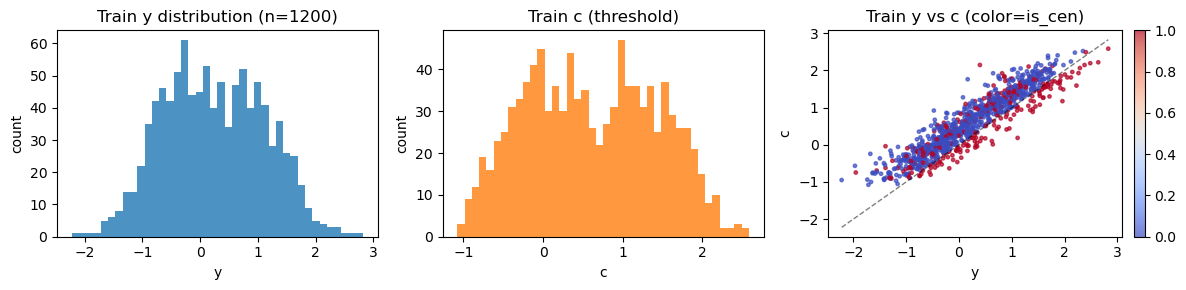

Train n=1200, censor_rate=0.293, w[min/med/max]=0.595/1.007/2.959


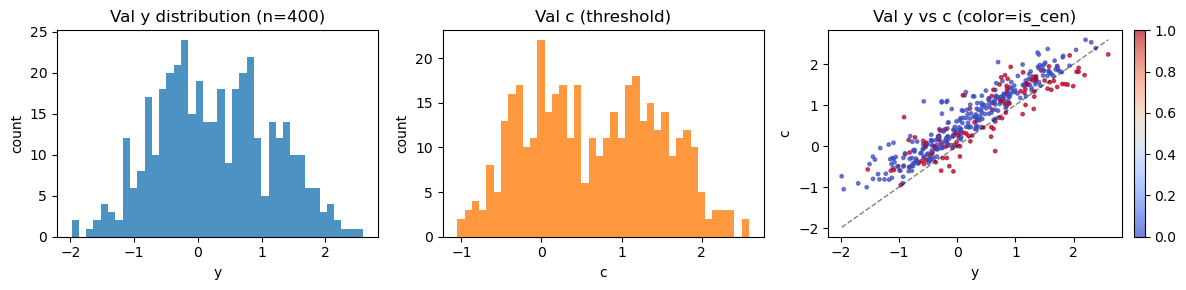

Val n=400, censor_rate=0.300, w[min/med/max]=0.614/1.000/3.029
Epoch 01 | train_loss=0.6549  val_loss=0.4779  val_RMSE_obs=0.6746
Epoch 02 | train_loss=0.1984  val_loss=0.1656  val_RMSE_obs=0.5828
Epoch 03 | train_loss=0.0351  val_loss=0.1089  val_RMSE_obs=0.5176
Epoch 04 | train_loss=-0.1297  val_loss=0.0705  val_RMSE_obs=0.5104


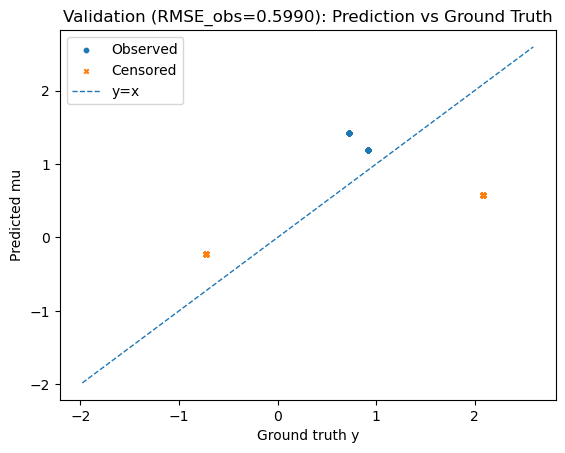

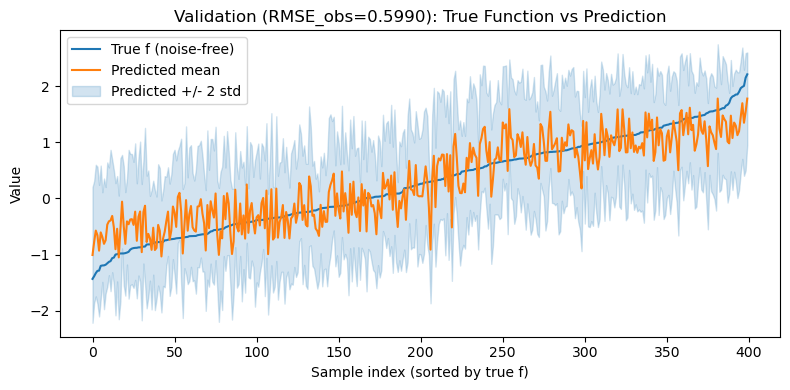

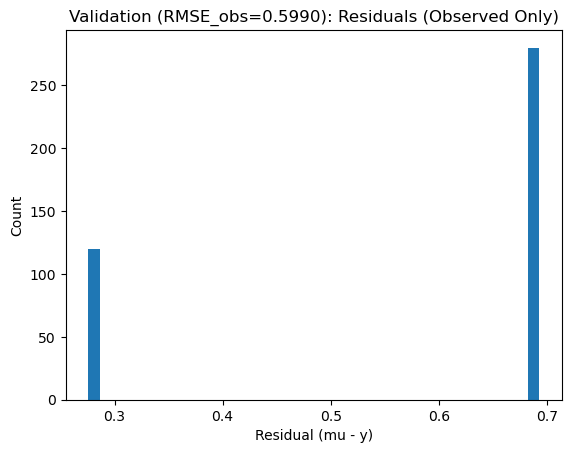

In [16]:
# ---
# Cell overview: execute the end-to-end training run using the above utilities, collect validation predictions, compute
# the observed-sample RMSE, and invoke all diagnostic plots including the true-function comparison with uncertainty.
# ---
# Tiny run for quick execution
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg = TrainConfig(epochs=4, batch_size=128, use_weighted_sampler=True, visualize_ds=True, viz_max=1000)
ds_train, ds_val, train_loader, val_loader = make_loaders(1200, 400, p=5, censor_rate=0.3, seed=42, cfg=cfg)
model = HeteroRegressor(in_dim=ds_train.x.shape[1], hidden=64).to(device)
history = fit(model, train_loader, val_loader, device, cfg)
val = predict(model, val_loader, device)
idx_obs = ~val['is_cen']
rmse = float(np.sqrt(np.mean((val['mu'][idx_obs] - val['y_true'][idx_obs])**2))) if idx_obs.any() else float('nan')
title_prefix = f'Validation (RMSE_obs={rmse:.4f})'
plot_pred_vs_true(val['y_true'], val['mu'], val['is_cen'], title_prefix=title_prefix)
plot_true_function_vs_pred(val.get('f_clean', np.array([])), val['mu'], val['std'], title_prefix=title_prefix)
plot_residuals(val['y_true'], val['mu'], val['is_cen'], title_prefix=title_prefix)

